In [24]:
import talib as ta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from iexfinance.stocks import get_historical_data
from datetime import datetime
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import scorer, accuracy_score

In [8]:
start = datetime(2015,1,1)
end = datetime(2018,1,1)

In [9]:
Df = get_historical_data('GLD', start=start, end=end, output_format='pandas')

In [10]:
print(Df.shape)
Df.head()

(755, 5)


,open,high,low,close,volume
date,,,,,
2015-01-02,112.49,114.80,112.32,114.08,7109594
2015-01-05,114.78,116.00,114.73,115.80,8177350
2015-01-06,116.22,117.50,115.80,117.12,11238313
2015-01-07,116.47,116.88,116.17,116.43,6434196
2015-01-08,116.45,116.87,115.85,115.94,7033675


In [11]:
split_percentage = 0.8
split = int(split_percentage * len(Df))

In [12]:
n = 10
Df['RSI'] = ta.RSI(np.array(Df['close'].shift(1)), timeperiod=n)
Df['SMA'] = ta.MA(Df['close'].shift(1), timeperiod=n)
Df['SAR'] = ta.SAR(np.array(Df['high'].shift(1)), np.array(Df['low'].shift(1)), 0.02, 0.2)
Df['ADX'] = ta.ADX(np.array(Df['high'].shift(1)), np.array(Df['low'].shift(1)), np.array(Df['open']), timeperiod=n)
Df['OO'] = Df['open'] - Df['open'].shift(1)
Df['OC'] = Df['open'] - Df['close'].shift(1)

In [13]:
Df['Ret'] = np.log(Df['close'].shift(-5) / Df['close'])
Df['Sig'] = 0
Df.loc[Df['Ret'] > Df['Ret'][:split].quantile(q=0.66), 'Sig'] = 1
Df.loc[Df['Ret'] < Df['Ret'][:split].quantile(q=0.33), 'Sig'] = -1

In [14]:
print(Df.shape)
Df = Df.dropna()
print(Df.shape)

(755, 13)
(730, 13)


In [15]:
X = Df.drop(['open','high','low','close','volume','Ret','Sig'], axis=1)

In [16]:
y = Df['Sig']

In [17]:
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

In [18]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [19]:
cls = SVC()
cls.fit(scaler.transform(X_train), y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [20]:
y_predict = cls.predict(scaler.transform(X_test))

In [21]:
Df['Sig'][split:] = y_predict

In [22]:
Df['Strategy_Return'] = Df['Sig'] * Df['Ret']

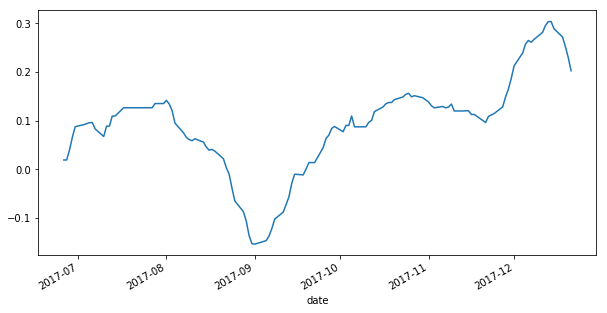

In [23]:
Df.Strategy_Return[split:].cumsum().plot(figsize=(10,5))

In [25]:
accuracy = accuracy_score(y_test, pd.DataFrame(cls.predict(scaler.transform(X_test))))

1.0